## Семинар 9: "LSTM"[SOLVED]

ФИО: __Федотова Алёна Дмитриевна__

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

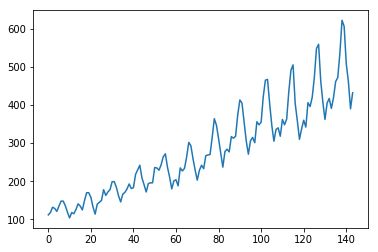

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготавливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


(96, 48)


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + 1:i + look_back + 1, 0])

    return np.array(dataX), np.array(dataY)

In [18]:
class DensedRec(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size, batch_size):
        super(DensedRec, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        if self.model_type == 'LSTM':
            self.rec = LSTM(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size, self.output_size)))
        elif self.model_type == 'nnLSTM':
            self.rec = nn.LSTM(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size, self.output_size)))
        elif self.model_type == 'nnGRU':
            self.rec = nn.GRU(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size, self.output_size)))
        else:
            print('Unknown model')
        
    def forward(self, inputs):
        inputs = inputs.permute(2, 0, 1)
        bs = inputs.size(1)
        if self.model_type == 'LSTM':
            hidden = (torch.zeros(bs, self.hidden_size),
                      torch.zeros(bs, self.hidden_size))
            pred, hidden = self.rec.forward(inputs, hidden)
            res = self.dense(pred)
            res = res.permute(1, 0, 2)[:, :, 0]
        if self.model_type == 'nnLSTM':
            hidden = (torch.zeros(1, bs, self.hidden_size),
                      torch.zeros(1, bs, self.hidden_size))
            pred, hidden = self.rec.forward(inputs, hidden)
            print pred.shape
            res = self.dense(pred)
            print res.shape
            res = res.permute(1, 0, 2)[:, :, 0]
            print res.shape
        if self.model_type == 'nnGRU':
            hidden = torch.zeros(1, bs, self.hidden_size)
            pred, hidden = self.rec.forward(inputs, hidden)
            res = self.dense(pred)
            res = res.permute(1, 0, 2)[:, :, 0]
        return res

In [26]:
from IPython.display import clear_output

def Train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False,
          optim=torch.optim.Adam, look_back=1):
    loss = nn.MSELoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)
    try:
        for epoch in range(epochs):
            losses = []
            network.train()
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                print y.shape
                break
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward(retain_graph=True)
                optimizer.step()
            scheduler.step()
            train_loss_epochs.append(np.mean(losses))
            losses = [] 
            network.eval()
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
            test_loss_epochs.append(np.mean(losses))
            if epoch % 10 == 0:
                pred = Predict(network, dataset[0:look_back], 150)
                
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
    
                plt.subplot(1, 2, 2)
                plt.plot(dataset, label='True')
                plt.plot(pred, label='Prediction')
                plt.legend()
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs

In [27]:
class NumPassDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [28]:
def Predict(network, start, pred_len):
    res = np.zeros(start.shape[0] + pred_len)
    res[:start.shape[0]] = start.reshape((len(start)))
    for i in range(pred_len):
        X = Variable(torch.Tensor(res[i:i + start.shape[0]]))
        X = X.reshape(1, 1, X.size(0))
        pred = network(X)
        res[i + start.shape[0]] = pred[0, -1]
    return res

In [33]:
def DoEverything(train, test, look_back, hidden_size, batch_size, model, epochs, learning_rate):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    dataset_train = NumPassDataset(trainX, trainY)
    dataset_test = NumPassDataset(testX, testY)
    
    print testY.shape
    return

    train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)
    
    input_size = 1
    output_size = 1

    network = DensedRec(model, input_size, hidden_size, output_size, batch_size)

    tr, te = Train(network, train_loader, test_loader, epochs, learning_rate, look_back=look_back)

In [34]:
DoEverything(train, test, look_back=10, hidden_size=10, batch_size=64,
             model='nnLSTM', epochs=1000, learning_rate=0.01)

(37, 10)


Epoch 990... (Train/Test) MSE: 0.00093/0.03677


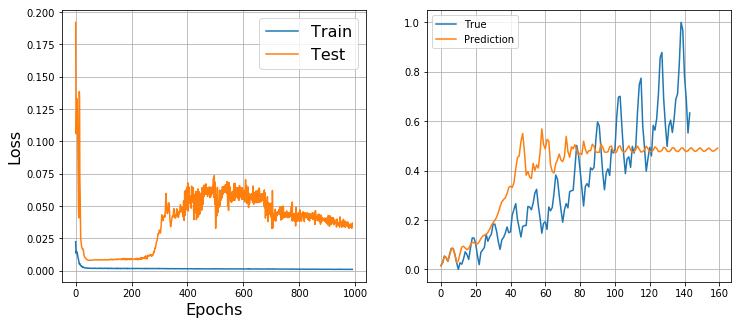

In [25]:
DoEverything(train, test, look_back=10, hidden_size=20, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00133/0.04075


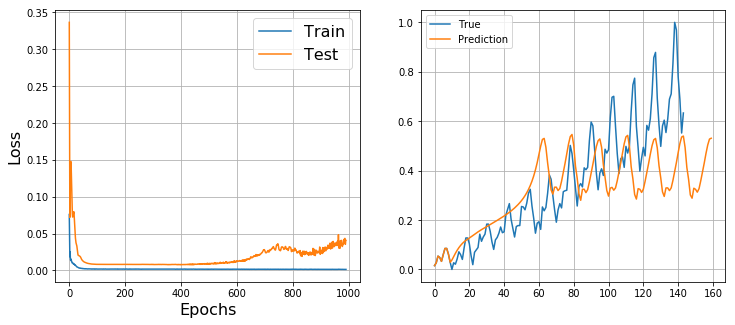

In [26]:
DoEverything(train, test, look_back=10, hidden_size=30, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00153/0.01660


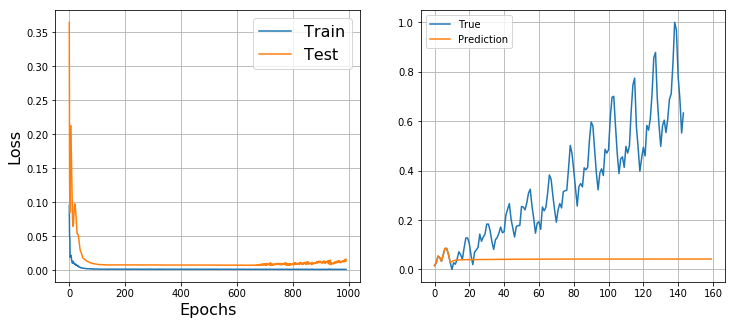

In [27]:
DoEverything(train, test, look_back=10, hidden_size=50, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00065/0.01168


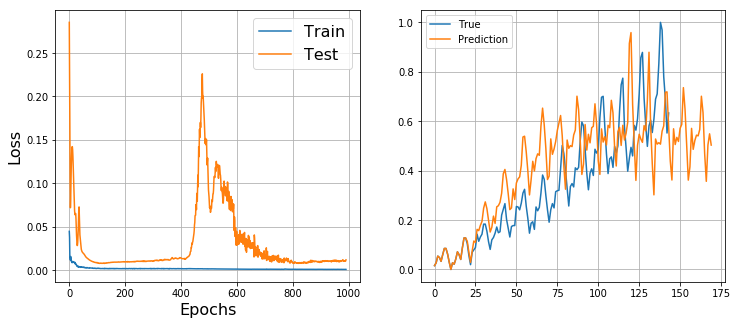

In [28]:
DoEverything(train, test, look_back=20, hidden_size=10, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00133/0.01065


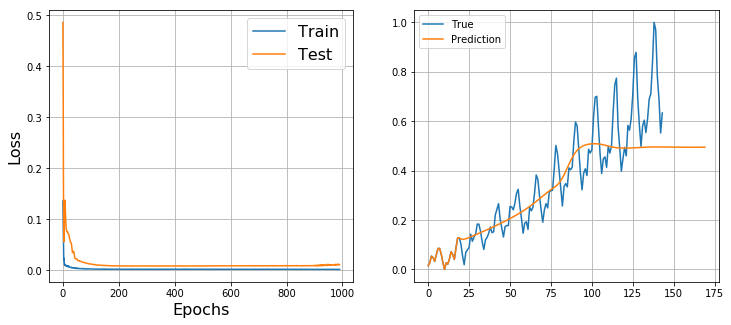

In [31]:
DoEverything(train, test, look_back=20, hidden_size=20, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00051/0.00970


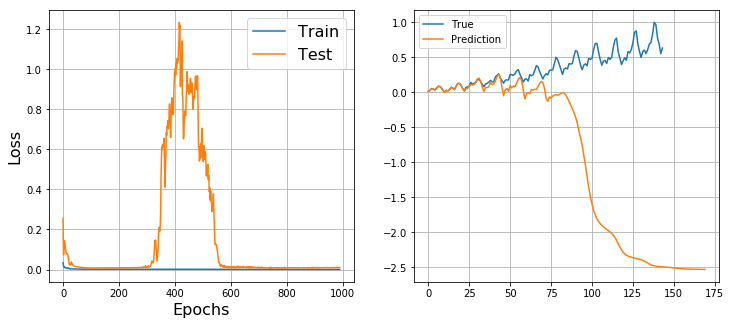

In [30]:
DoEverything(train, test, look_back=20, hidden_size=30, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00065/0.01213


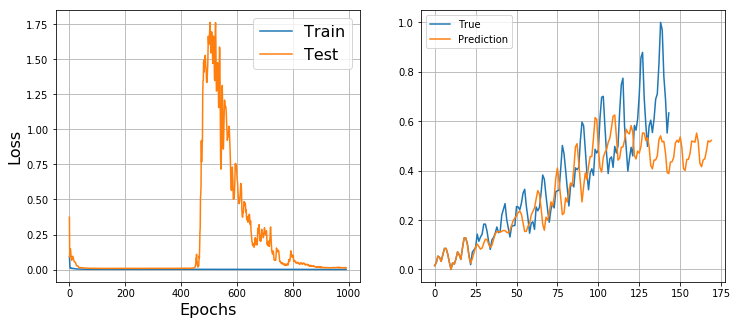

In [31]:
DoEverything(train, test, look_back=20, hidden_size=50, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00079/0.01810


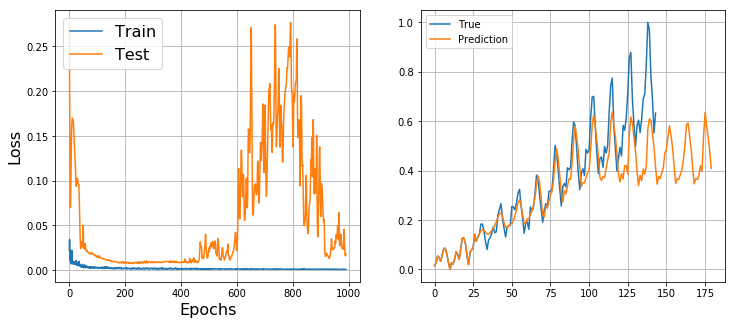

In [32]:
DoEverything(train, test, look_back=30, hidden_size=10, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00044/0.00666


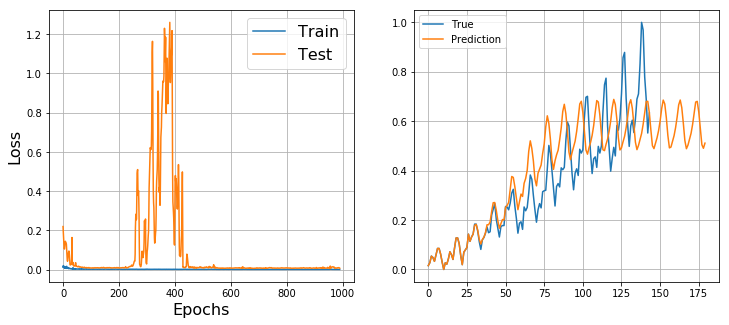

In [34]:
DoEverything(train, test, look_back=30, hidden_size=20, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00039/0.00903


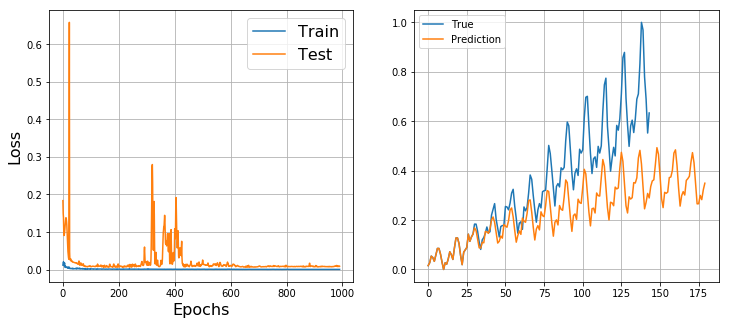

In [37]:
DoEverything(train, test, look_back=30, hidden_size=30, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00054/0.01415


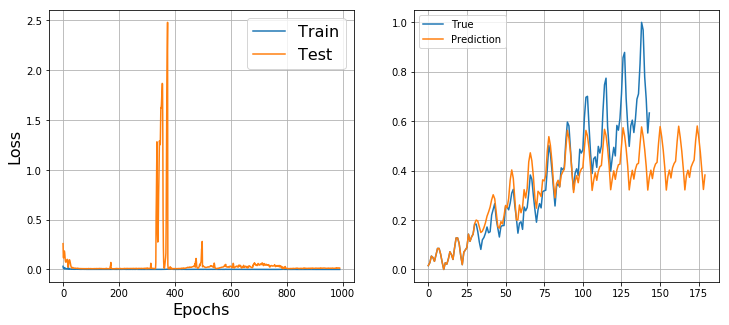

In [12]:
DoEverything(train, test, look_back=30, hidden_size=50, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00036/0.01191


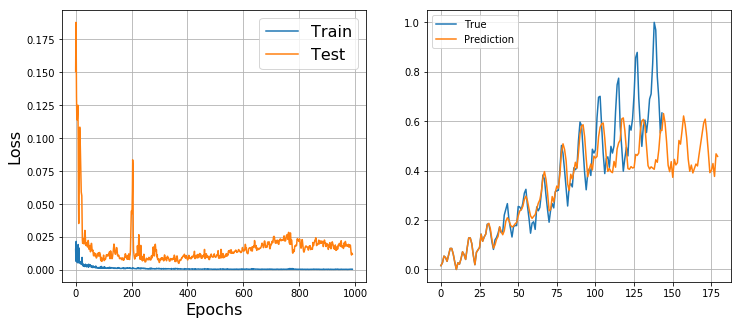

In [32]:
DoEverything(train, test, look_back=30, hidden_size=30, batch_size=64,
             model='nnLSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00031/0.00910


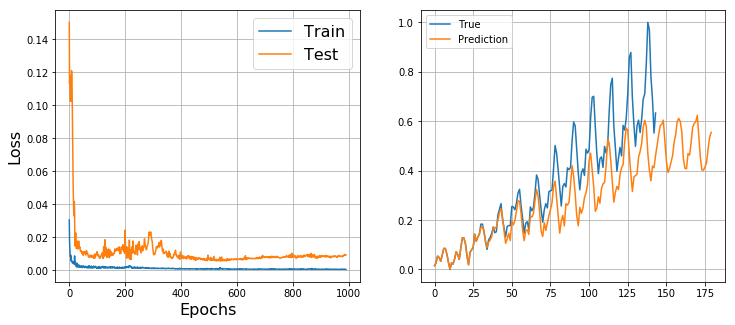

In [33]:
DoEverything(train, test, look_back=30, hidden_size=30, batch_size=64,
             model='nnGRU', epochs=1000, learning_rate=0.01)

# Предсказывание следующего элемента

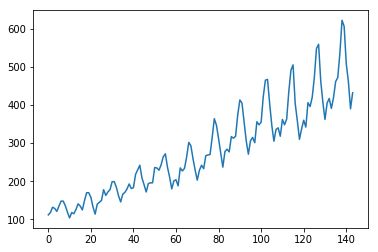

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготавливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
# Целевая переменная - следующий элемент

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [65]:
class DensedRec(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size, batch_size, seq_len):
        super(DensedRec, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        if self.model_type == 'LSTM':
            self.rec = LSTM(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size * self.seq_len, self.output_size)))
        elif self.model_type == 'nnLSTM':
            self.rec = nn.LSTM(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size * self.seq_len, self.output_size)))
        elif self.model_type == 'nnGRU':
            self.rec = nn.GRU(input_size, hidden_size)
            self.dense = nn.Sequential((nn.Linear(self.hidden_size * self.seq_len, self.output_size)))
        else:
            print('Unknown model')
        
    def forward(self, inputs):
        inputs = inputs.permute(2, 0, 1)
        bs = inputs.size(1)
        if self.model_type == 'LSTM':
            hidden = (torch.zeros(bs, self.hidden_size),
                      torch.zeros(bs, self.hidden_size))
            pred, hidden = self.rec.forward(inputs, hidden)
            pred = pred.permute(1, 0, 2)
            pred = pred.contiguous().view(bs, -1)
            res = self.dense(pred)
            res = res[:, 0]
        if self.model_type == 'nnLSTM':
            hidden = (torch.zeros(1, bs, self.hidden_size),
                      torch.zeros(1, bs, self.hidden_size))
            pred, hidden = self.rec.forward(inputs, hidden)
            pred = pred.permute(1, 0, 2)
            pred = pred.contiguous().view(bs, -1)
            res = self.dense(pred)
            res = res[:, 0]
        if self.model_type == 'nnGRU':
            hidden = torch.zeros(1, bs, self.hidden_size)
            pred, hidden = self.rec.forward(inputs, hidden)
            pred = pred.permute(1, 0, 2)
            pred = pred.contiguous().view(bs, -1)
            res = self.dense(pred)
            res = res[:, 0]
        return res

In [73]:
 

def Train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False,
          optim=torch.optim.Adam, look_back=1):
    loss = nn.MSELoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)
    try:
        for epoch in range(epochs):
            losses = []
            network.train()
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward(retain_graph=True)
                optimizer.step()
            scheduler.step()
            train_loss_epochs.append(np.mean(losses))
            losses = [] 
            network.eval()
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
            test_loss_epochs.append(np.mean(losses))
            if epoch % 10 == 0:
                pred = Predict(network, dataset[0:look_back], 150 - look_back)
                
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
    
                plt.subplot(1, 2, 2)
                plt.plot(dataset, label='True')
                plt.plot(pred, label='Prediction')
                plt.legend()
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs

In [74]:
class NumPassDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [75]:
def Predict(network, start, pred_len):
    res = np.zeros(start.shape[0] + pred_len)
    res[:start.shape[0]] = start.reshape((len(start)))
    for i in range(pred_len):
        X = Variable(torch.Tensor(res[i:i + start.shape[0]]))
        X = X.reshape(1, 1, X.size(0))
        pred = network(X)
        res[i + start.shape[0]] = pred[0]
    return res

In [76]:
def DoEverything(train, test, look_back, hidden_size, batch_size, model, epochs, learning_rate):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    dataset_train = NumPassDataset(trainX, trainY)
    dataset_test = NumPassDataset(testX, testY)

    train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)
    
    input_size = 1
    output_size = 1

    network = DensedRec(model, input_size, hidden_size, output_size, batch_size, look_back)

    tr, te = Train(network, train_loader, test_loader, epochs, learning_rate, look_back=look_back)

Epoch 990... (Train/Test) MSE: 0.00069/0.07541


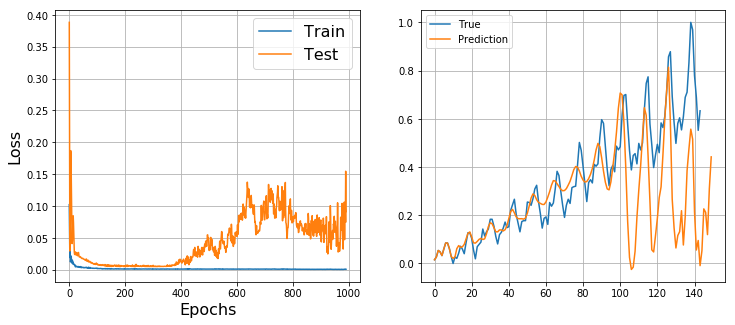

In [77]:
DoEverything(train, test, look_back=10, hidden_size=20, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

Epoch 990... (Train/Test) MSE: 0.00017/0.00156


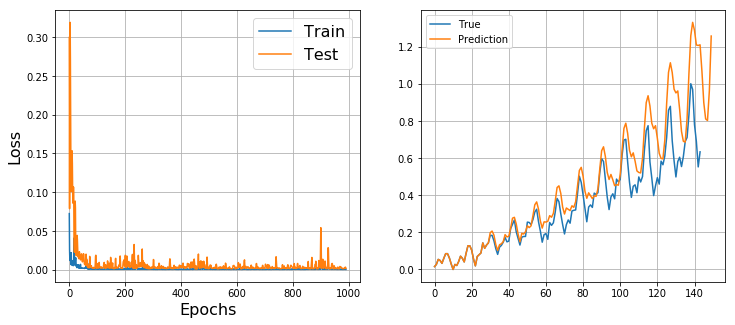

In [78]:
DoEverything(train, test, look_back=30, hidden_size=30, batch_size=64,
             model='LSTM', epochs=1000, learning_rate=0.01)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: